In [1]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common import make_vec_env
from stable_baselines import A2C
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines.common.evaluation import evaluate_policy
import tensorflow as tf
from stable_baselines.common.callbacks import BaseCallback

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
import gym
import w_mac
from collections import defaultdict
import matplotlib as plt
import networkx as nx
import dill
from copy import deepcopy
from ray import tune

defaultdict(<class 'list'>, {0: [2, 1, 3], 1: [2, 3], 2: [3, 4], 3: [4], 5: [2, 3, 4]})


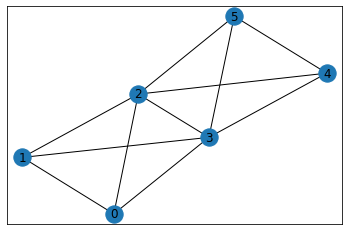

In [3]:

# data = [(0,2),(0,1),(1,2),(2,3),(2,4),(3,4)]
#data = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3),(2,4),(2,5),(3,4),(3,5),(4,5),(4,8),(4,9),(5,6),(6,7),(5,7),(8,9),(6,9)]#,(6,8),(7,8),(8,9),(9,10)]
d = defaultdict(list)
data = [(0,2),(0,1),(0,3),(1,2),(1,3),(2,3),(2,4),(3,4),(5,2),(5,3),(5,4)]
for node, dest in data:
    d[node].append(dest)
print(d)

G = nx.Graph()
for k,v in d.items():
    for vv in v:
        G.add_edge(k,vv)
nx.draw_networkx(G)

self.collision_domain {5: [0, 1, 2, 3], 8: [2, 3, 4, 5]}
self.node_in_domains :  {0: [5], 1: [5], 2: [5, 8], 3: [5, 8], 4: [8], 5: [8]}
self.attack_nodes [2]
self.node_action_list {0: [0, 1, 2, 3], 2: [0, 1, 2, 3, 4, 5], 1: [0, 1, 2, 3], 3: [0, 1, 2, 3, 4, 5], 4: [2, 3, 4, 5], 5: [2, 3, 4, 5]}
sorted self.node_action_list {0: [0, 1, 2, 3], 2: [0, 1, 2, 3, 4, 5], 1: [0, 1, 2, 3], 3: [0, 1, 2, 3, 4, 5], 4: [2, 3, 4, 5], 5: [2, 3, 4, 5]}
action_space MultiDiscrete([4 6 4 6 4 4])
MultiDiscrete([7 7 7 7 7 7 6])
[5 1 3 4 2 6 2]


array([5, 4, 2, 6, 2, 1, 3])

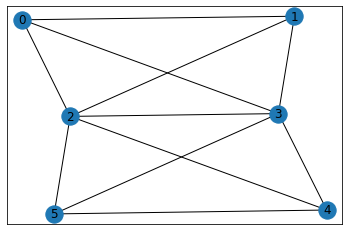

In [4]:
env = gym.make('wmac-graph-v0',graph=G)
#env = gym.make('wmac-tune-v0')
env.reset()

In [5]:
check_env(env)

In [6]:
assert(dill.pickles(env))

In [7]:
dill.pickles(env)

True

In [9]:
def evaluate_objective(config):
    tune_env = deepcopy(env)
    tune_agent = A2C("MlpPolicy", tune_env, learning_rate= config["lr"] )
    tune_agent.learn(total_timesteps=10)
    
    mean_reward, std_reward = evaluate_policy(tune_agent, env, n_eval_episodes=10, render=False,
                                                           deterministic=True,
                                                           return_episode_rewards=False)
    print("mr",mean_reward,"sd", std_reward)
    tune.report(mean_reward=mean_reward)
    

In [10]:
tune.utils.diagnose_serialization(evaluate_objective)

Trying to serialize <function evaluate_objective at 0x7fa74ab92830>...
Serialization succeeded!


True

In [ ]:
from ray import tune
from ray.tune.suggest.ax import AxSearch

parameters=[
    {"name": "learning_rate", "type": "range", "bounds": [3e-4, 3e-1]},
    {"name": "gamma", "type": "range", "bounds": [0.99, 1.0]},
    {"name": "max_grad_norm", "type": "range", "bounds": [0.3, 7.0]}
]   

        
def evaluate_objective(config):
    tune_env = deepcopy(env)
    tune_agent = A2C("MlpPolicy", tune_env, 
                     gamma = config["gamma"],
                     max_grad_norm = config["max_grad_norm"],
                     learning_rate= config["learning_rate"]
                    )#**config)
    tune_agent.learn(total_timesteps=100000)
    
    mean_reward, std_reward = evaluate_policy(tune_agent, env, n_eval_episodes=10, render=False,
                                                           deterministic=True,
                                                           return_episode_rewards=False)
    print("mr",mean_reward,"sd", std_reward)
    tune.report(mean_reward=mean_reward)
    

ax_search = AxSearch(space=parameters, metric="mean_reward", mode = "max")
analysis = tune.run(evaluate_objective,
         num_samples=4,
         search_alg=ax_search,
         resources_per_trial={"cpu": 4}
        )

In [ ]:
### Working grid search tunning

"""
from ray import tune

analysis = tune.run(
    evaluate_objective,
    num_samples=3,
    config={
        "lr": tune.grid_search([0.001, 0.01, 0.1]),
    },
    metric="mean_reward",
    mode="max",
    resources_per_trial={"cpu": 2}
    )
"""

In [ ]:
best_config = analysis.best_config
print(best_config)